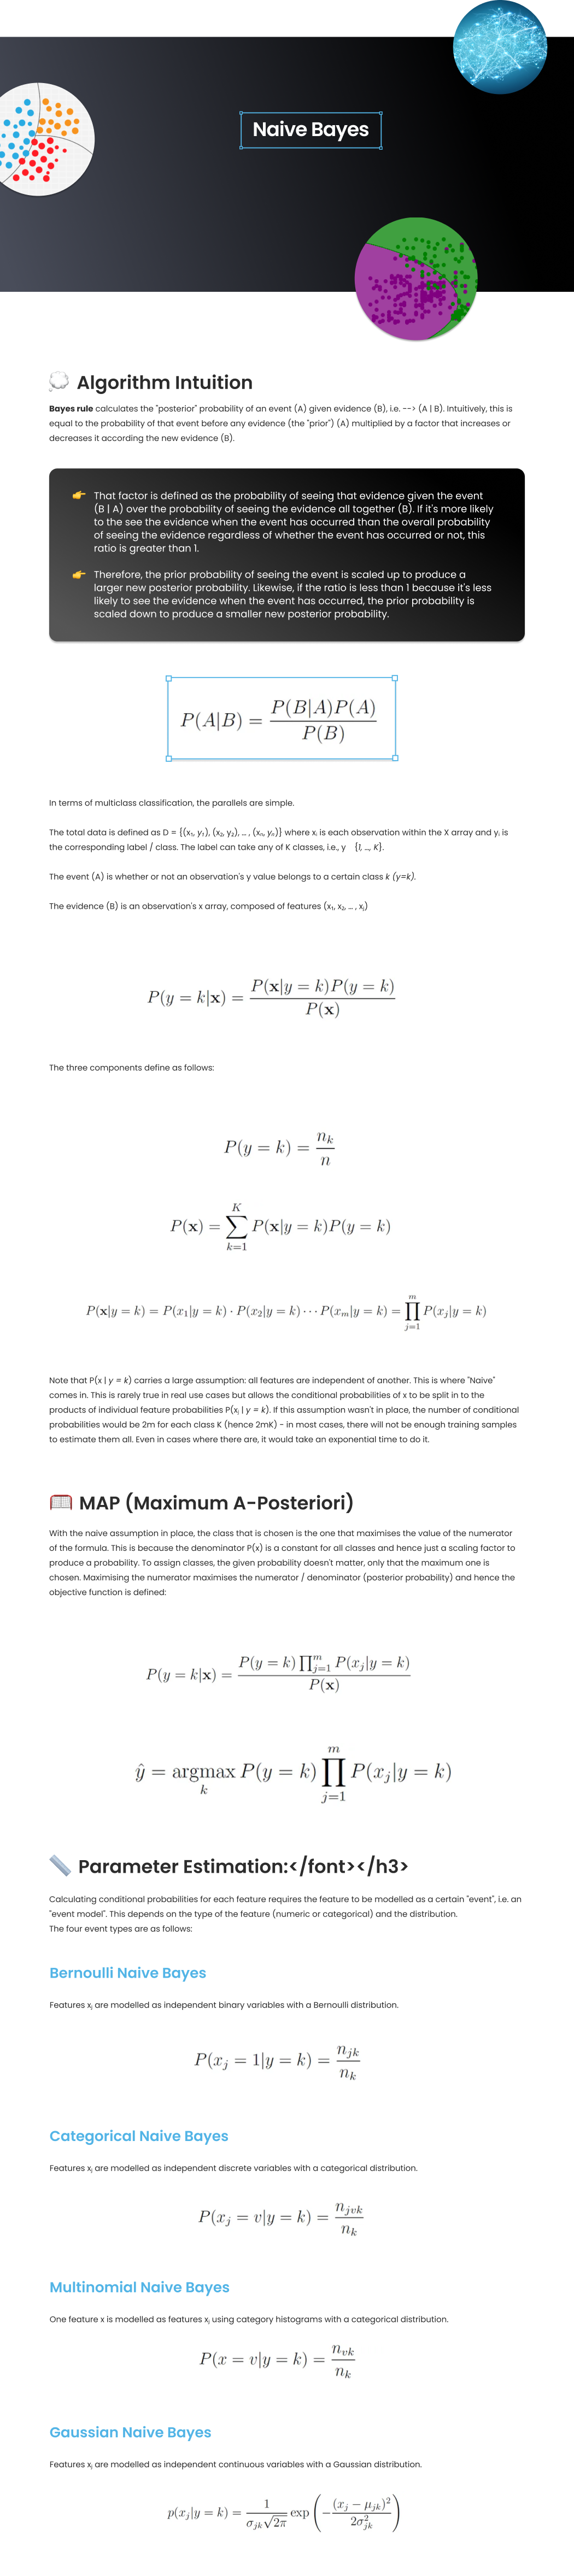

In [283]:
from IPython.display import Image
Image("images\Figma_Naive_Bayes.png")

*Import Libraries*

In [263]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTEN
from sklearn.metrics import precision_recall_curve, auc


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [264]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [265]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*sklearn implements all 4 NB event models <b>separately</b>. In order to model, must turn all features to one type of event*<br>
*<b>Choice:</b> all become Bernoulli. Binning numerical features*

*Preprocess steps*

In [266]:
# SET UP AND VERIFICATION OF TRANSFORMERS STEPS BEFORE PIPELINE

# Create a custom binner for df transform
binner = settings.CustomBinnerNB()

# Transform step 1
binned_X_train_array = binner.fit_transform(X_train)
binned_X_test_array = binner.transform(X_test)

# Retrieve new column names for OneHotEncoder
ALL_FEATURES_BINS = binned_X_train_array.columns 

# Create a column transformer for encoding
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore'), ALL_FEATURES_BINS)
    ],
    remainder='passthrough')

# Transform step 2
transformed_X_train_array = column_trans.fit_transform(binned_X_train_array)
transformed_X_test_array = column_trans.transform(binned_X_test_array)

# # Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# # Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [267]:
# create model
model_nb = CategoricalNB()

# create sklearn pipeline
pipeline_nb = settings.create_pipeline(["Binner", binner],
                                        ["Preprocess", column_trans], 
                                        ["Bernoulli_naive_bayes", model_nb])

# create cross validation object for cross_val_score
cv_nb = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_nb, X_train, y_train, scoring=custom_scorer, cv=cv_nb)

settings.cross_val_summary(pipeline_nb, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 83.700 %
Mean CV Train Score: 80.5500 % ( +- 5.900 % )
Test Score: 86.600 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96        66
           1       0.84      0.88      0.86        24
           2       0.84      0.91      0.87        23

    accuracy                           0.92       113
   macro avg       0.89      0.91      0.90       113
weighted avg       0.92      0.92      0.92       113



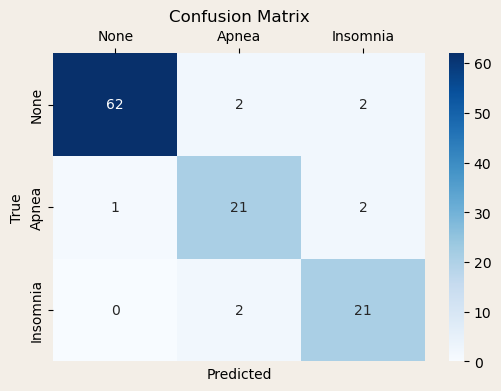

In [268]:
# Generate prediction and show classification report
y_pred = pipeline_nb.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Decent baseline train cv positive class F1 score 80.6% and higher test 86.6%. Test score is far above CV score and also above train score which suggests random seed 42 created an unrepresentative train_test split for this model. Data split must be consistent across models to be used for majority vote. High Test > Train score is a concern.</li>
    <li>High variation in cv scores: 5.9%</li> 
    <li>Baseline model successfully separates Apnea and Insomnia with high recalls for both positive classes. However, it seems false positives have been increased (lower precision) in this pursuite. Particularly from the None class - i.e. the false alarm case. False alarms aren't as harmful as mixing positive classes so not as important.    
</ul>
</div>


In [269]:
# Save baseline pipeline to file  
settings.save_pipeline("best_naive_bayes_classification_pipeline.pkl", pipeline_nb)

*Hyperparam tuning*

*Smoothing*

In [270]:
# set up param grid
param_grid_nb = {
    'Bernoulli_naive_bayes__alpha': np.linspace(0.1, 1, 10) # default is 1
}

# Create and fit GridSearchCV object on train data
grid_search_nb = GridSearchCV(pipeline_nb, param_grid=param_grid_nb, scoring=custom_scorer, cv=cv_nb, n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_nb, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,Bernoulli_naive_bayes__alpha
0,0.2


---------------------
Using best parameters
---------------------
Train Score: 84.100 %
Mean CV Train Score: 81.400 % ( +- 6.000 % )
Test Score: 84.500 %


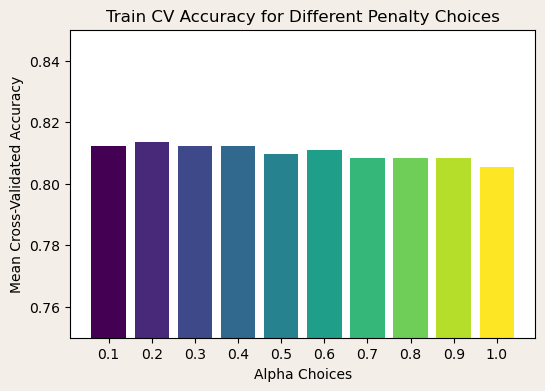

In [271]:
# Access the grid search results
results = grid_search_nb.cv_results_

# Extract C values and accuracy scores
alpha_values = results['param_Bernoulli_naive_bayes__alpha'].data
alpha_values = [str(val)[:3] for val in alpha_values] 
mean_test_scores = results['mean_test_score'].data

# Use a color map for the bars
cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(alpha_values)))

# Plot the bars with specified colors
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
bars = ax.bar(alpha_values, mean_test_scores, color=colors)

# Add plot details
ax.set_ylim(0.75, 0.85)
ax.set_xlabel('Alpha Choices')
ax.set_ylabel('Mean Cross-Validated Accuracy')
ax.set_title('Train CV Accuracy for Different Penalty Choices')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Cross validated F1 score improved marginally using an alpha level of 0.2</li> 
    <li>However, test accuracy has not increased showing less ability to generalise.</li>
</ul>
</div>


Test Accuracy: 92.0400 %


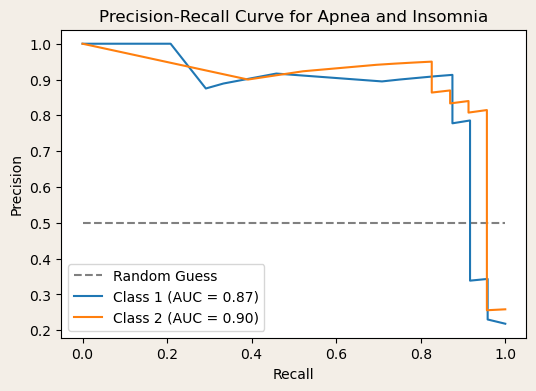

In [272]:
# Print test accuracy
pipeline_nb.fit(X_train, y_train)
print("Test Accuracy:", settings.score_formatter(pipeline_nb.score(X_test, y_test), 4))

# Calculate probabilities of each class
y_scores = pipeline_nb.predict_proba(X_test)

# Calculate precision-recall pairs and AUC for each positive class
precision = {}
recall = {}
pr_auc = {}

for class_idx in [1, 2]:  # Select positive classes Apnea and Insomnia
    y_scores_class = y_scores[:, class_idx]
    y_test_class = (y_test == class_idx).astype(int)
    
    precision[class_idx], recall[class_idx], _ = precision_recall_curve(y_test_class, y_scores_class)
    pr_auc[class_idx] = auc(recall[class_idx], precision[class_idx])

# Plot the precision-recall curves for each positive class
plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
plt.plot([0, 1], [0.5, 0.5], linestyle='--', color='gray', label='Random Guess')
for class_idx in [1, 2]:
    plt.plot(recall[class_idx], precision[class_idx], label=f'Class {class_idx} (AUC = {pr_auc[class_idx]:.2f})')
ax.set_ylim(0.0, 1.0)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Apnea and Insomnia')
plt.legend()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Overall Accuracy of model is very good at 93.8% test set although, as descussed above, the figure is questionable with this data split.
    <li>Average AUC on the Precision-Recall of both positive classes is high at 87% of Apnea and 90% for Insmonia showing support for a skillful positive class classifier. A PR curve's theory: when threshold for assigning positive class is very high (~100%), only a few very confident predictions will be make it, resulting in very high precision but very low recall. Conversely, when threshold is very low (~0%), all predictions will make it, resulting in a very high recall but a precision equal to the proportion of that class out of all samples (~25% each for both) </li>
    <li>Class level recall and precision is still as described before.</li>
</ul>
</div>


*Exploring SMOTE-NC for Class Imbalance:*

In [273]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
smote_n = SMOTEN(random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_n.fit_resample(transformed_X_train_array, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")


Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [274]:
# SET UP AND VERIFICATION OF TRANSFORMERS STEPS BEFORE PIPELINE

# Create a custom binner for df transform
binner = settings.CustomBinnerNB()

# Transform step 1
binned_X_train_array = binner.fit_transform(X_train)
binned_X_test_array = binner.transform(X_test)

# Retrieve new column names for OneHotEncoder
ALL_FEATURES_BINS = binned_X_train_array.columns 

# Create a column transformer for encoding
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse = False, handle_unknown='ignore'), ALL_FEATURES_BINS)
    ],
    remainder='passthrough')

# Transform step 2
transformed_X_train_array = column_trans.fit_transform(binned_X_train_array)
transformed_X_test_array = column_trans.transform(binned_X_test_array)

In [275]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('binner', binner), ('column_trans', column_trans), ('smote', smote_n), ("bernoulli_naive_bayes", model_nb)]
pipeline_nb = Pipeline_imb(steps)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_nb, X_train, y_train, scoring=custom_scorer, cv=cv_nb)

settings.cross_val_summary(pipeline_nb, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)

Train Score: 84.400 %
Mean CV Train Score: 82.5700 % ( +- 6.500 % )
Test Score: 87.500 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.84      0.88      0.86        24
           2       0.88      0.91      0.89        23

    accuracy                           0.93       113
   macro avg       0.90      0.91      0.91       113
weighted avg       0.93      0.93      0.93       113



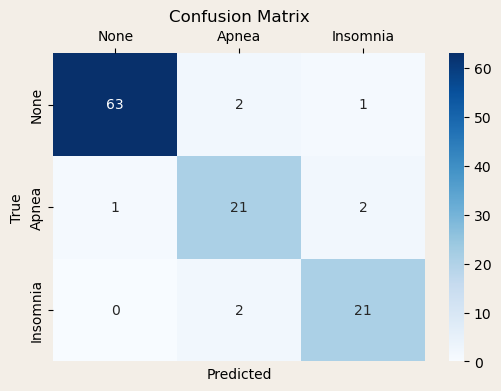

In [212]:
# Generate prediction and show classification report
y_pred = model_nb.predict(transformed_X_test_array)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>SMOTE train cv F1 score improved very slightly to 82.6%</li> 
    <li>Test score improved to 87.5%: one less None sample is misclassified as Insomnia.</li>
</ul>
</div>


In [213]:
# Save baseline pipeline to file  
settings.save_pipeline("best_naive_bayes_classification_pipeline.pkl", pipeline_nb)

In [276]:
# set up param grid
param_grid_nb = {
    'bernoulli_naive_bayes__alpha': np.linspace(0.1, 1, 10) # default is 1
}

# Create and fit GridSearchCV object on train data
grid_search_nb = GridSearchCV(pipeline_nb, param_grid=param_grid_nb, scoring=custom_scorer, cv=cv_nb, n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_nb, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,bernoulli_naive_bayes__alpha
0,0.2


---------------------
Using best parameters
---------------------
Train Score: 84.400 %
Mean CV Train Score: 82.800 % ( +- 6.500 % )
Test Score: 87.500 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.84      0.88      0.86        24
           2       0.88      0.91      0.89        23

    accuracy                           0.93       113
   macro avg       0.90      0.91      0.91       113
weighted avg       0.93      0.93      0.93       113



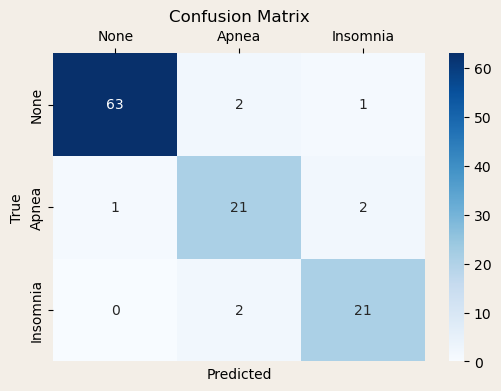

In [280]:
pipeline_nb = grid_search_nb.best_estimator_
y_pred = pipeline_nb.predict(X_test)

# Generate prediction and show classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>tuned SMOTE improved cv F1 score very slightly to 82.8%</li> 
    <li>Test score didn't improve but with improved CV score, model will be saved as best found.</li>
</ul>
</div>


In [281]:
# Save baseline pipeline to file  
settings.save_pipeline("best_naive_bayes_classification_pipeline.pkl", pipeline_nb)